In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

natgas_df = pd.read_csv('Nat_Gas.csv')

from scipy.optimize import curve_fit

In [2]:
#Convert Dates to datetime
natgas_df['Dates'] = pd.to_datetime(natgas_df['Dates'])

C:\Users\tanis\AppData\Local\Temp\ipykernel_8944\1939795658.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  natgas_df['Dates'] = pd.to_datetime(natgas_df['Dates'])


In [3]:
days_in_month = 30.44
natgas_df['Months_Since_Start'] = (natgas_df['Dates'] - natgas_df['Dates'].min()).dt.days / days_in_month

In [4]:
def linear_sin_model(x, a, b, c, d, e, f):
    '''
    Created a combination of liner and sin function 
    using parameters 
    x : input date array
    a b c : Coefficients for linear component (a*x + b + c)
    d e f : Coefficients for sin component : d *sin(2*pi*(e*x + f)) 
    Returns : 
            predicted gas prices based on the input data array
    '''
    return a * x + b + c + d * np.sin(2*np.pi * (e * x + f)) 

# Fitting the Model
x_data = natgas_df['Months_Since_Start']
y_data = natgas_df['Prices']
params, params_covariance = curve_fit(linear_sin_model, x_data, y_data, p0=[0.01, 10, 0, 1, 0.1, 0])

params

# Predict using the fitted model across the data range
x_model = np.linspace(x_data.min(),x_data.max(), 300)
y_model = linear_sin_model(x_model, *params)

# Convert Months Since Start back to Dates for x-axis
start_date = natgas_df['Dates'].min()
x_model_dates = start_date + pd.to_timedelta(x_model * days_in_month, unit='D')  # Approximate each month as 30.44 days


In [6]:
'''
def fit_gas_price(dates, prices):
    # normalize the dates to start from 0
    start_date = min(dates)
    normalized_dates = np.array(dates) - start_date

    # Perform curve fitting to obtain the model coefficients
    coeffs, _ = curve_fit(linear_sin_model, normalized_dates, prices)

    # Unpack the coefficients 
    a, b, c, d, e, f = coeffs

    # Create and return the prediction function 
    def predict_gas_price(date):
        #normalize the input date
        normalized_date = date - start_date

        # Use the model to predict gas price for  the given date
        return linear_sin_model(normalized_date, a, b, c, d, e, f)
    
    return predict_gas_price

# Gas price data 
dates = np.arange(48) # Montly dates index
gas_prices = natgas_df['Prices'] #  Corresponding monthly gas  prices 

# Fit the data and obtain the prediction function 
predict_gas_price = fit_gas_price(dates, gas_prices)

specific_date = 57
predicted_price = predict_gas_price(specific_date)
print("Predicted gas price for specific date :", predicted_price)

'''

'\ndef fit_gas_price(dates, prices):\n    # normalize the dates to start from 0\n    start_date = min(dates)\n    normalized_dates = np.array(dates) - start_date\n\n    # Perform curve fitting to obtain the model coefficients\n    coeffs, _ = curve_fit(linear_sin_model, normalized_dates, prices)\n\n    # Unpack the coefficients \n    a, b, c, d, e, f = coeffs\n\n    # Create and return the prediction function \n    def predict_gas_price(date):\n        #normalize the input date\n        normalized_date = date - start_date\n\n        # Use the model to predict gas price for  the given date\n        return linear_sin_model(normalized_date, a, b, c, d, e, f)\n    \n    return predict_gas_price\n\n# Gas price data \ndates = np.arange(48) # Montly dates index\ngas_prices = natgas_df[\'Prices\'] #  Corresponding monthly gas  prices \n\n# Fit the data and obtain the prediction function \npredict_gas_price = fit_gas_price(dates, gas_prices)\n\nspecific_date = 57\npredicted_price = predict_gas_

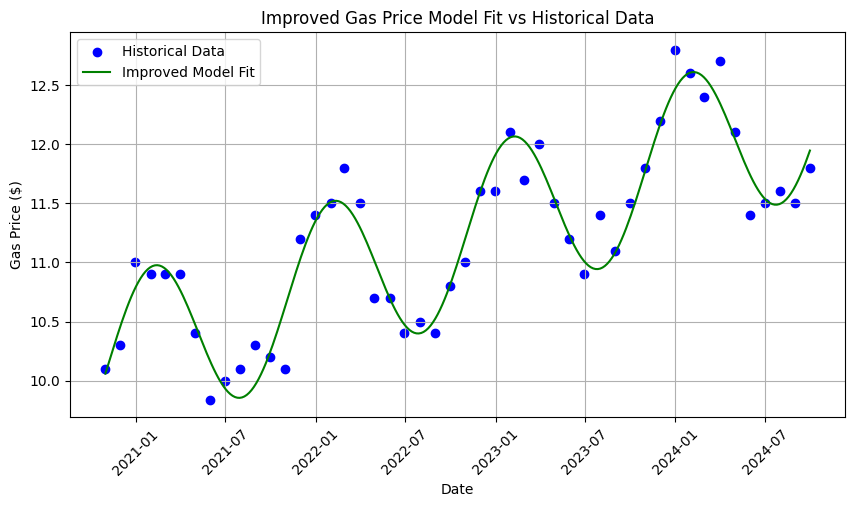

In [5]:
# Plotting the new fit
plt.figure(figsize=(10,5))
plt.scatter(natgas_df['Dates'], y_data, color = 'blue', label = 'Historical Data')
plt.plot(x_model_dates, y_model, color = 'green', linestyle='-', label='Improved Model Fit')
plt.title('Improved Gas Price Model Fit vs Historical Data')
plt.xlabel('Date')
plt.ylabel('Gas Price ($)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [8]:
def predict_gas_price(date):
    # Convert input into str to datetime
    try:
        input_date = pd.to_datetime(date)
    except Exception as e:
        raise ValueError("Invalid date format") from e

    # Check if the date exist in the historical data
    if input_date in natgas_df['Dates'].values:
        return natgas_df.loc[natgas_df['Dates'] == input_date, 'Prices'].values[0]
    else:
        months_since_start = (input_date - start_date).days / days_in_month

        predicted_price = linear_sin_model(months_since_start, *params)
        return predicted_price
    
# Test
test_date_historical = "12/31/22"
test_date_future = "4/30/25"

Test_1 = predict_gas_price(test_date_historical)
Test_2 = predict_gas_price(test_date_future)
print(f"Test Run {test_date_historical}: ${Test_1:.2f}")
print(f"Test Run {test_date_future}: ${Test_2:.2f}")

Test Run 12/31/22: $11.60
Test Run 4/30/25: $12.58


In [9]:
# Calculate the value of the gas storage contract using predicted gas prices
def calculate_contract_value_model(injection_dates, withdrawal_dates, injection_rate, injection_withdrawal_costs, max_storage_volume, storage_cost_per_month):
    total_profit = 0
    avg_num_days_per_months = 30.42

    for i in range(len(injection_dates)):
        injection_price = predict_gas_price(injection_dates[i])
        print('injection_price:', injection_price)
        withdrawal_price = predict_gas_price(withdrawal_dates[i])
        print('withdrawal_price:', withdrawal_price)

        # Calculate the number of months the gas is stored
        months_in_store = round((pd.to_datetime(withdrawal_dates[i]) - pd.to_datetime(injection_dates[i])).days / avg_num_days_per_months)
        print('months_in_store:', months_in_store)

        # Calculate the total injected volume
        total_injected_volume = min(months_in_store * injection_rate, max_storage_volume)
        print('total_injected_volume:', total_injected_volume)

        # Calculate the cost of injection
        cost_of_injection = (total_injected_volume * injection_price) - (total_injected_volume / 1000000 * injection_withdrawal_costs)
        print('cost_of_injection:', cost_of_injection)

        # Calculate the revenue from sale
        revenue_from_sale = total_injected_volume * withdrawal_price - (total_injected_volume / 1000000 * injection_withdrawal_costs)
        print('revenue_from_sale:', revenue_from_sale)

        # Calculate the total storage cost
        total_storage_cost = months_in_store * storage_cost_per_month
        print('total_storage_cost:', total_storage_cost)

        # Calculate the total profit
        total_profit += (revenue_from_sale - cost_of_injection - total_storage_cost)

    return total_profit

# Test
injection_dates = ['10/31/2024']
withdrawal_dates = ['2/28/2025']
injection_rate = 1000000
injection_withdrawal_costs = 10000
max_storage_volume = 5000000
storage_cost_per_month = 100000

#Testing
contract_value = calculate_contract_value_model(injection_dates, withdrawal_dates, injection_rate, injection_withdrawal_costs, max_storage_volume, storage_cost_per_month)
print('Contract Value:', contract_value)

injection_price: 12.349197914562161
withdrawal_price: 13.096962949507315
months_in_store: 4
total_injected_volume: 4000000
cost_of_injection: 49356791.65824865
revenue_from_sale: 52347851.79802926
total_storage_cost: 400000
Contract Value: 2591060.139780611


C:\Users\tanis\AppData\Local\Temp\ipykernel_12640\2599421072.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  natgas_test_df['Dates'] = pd.to_datetime(natgas_test_df['Dates'])


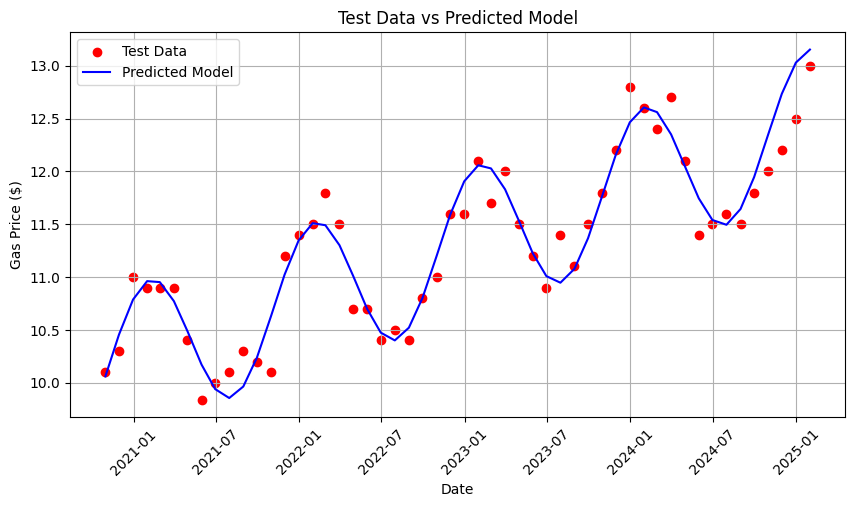

In [10]:
# Load the test data
natgas_test_df = pd.read_csv('Nat_Gas_Test.csv')

# Convert Dates to datetime
natgas_test_df['Dates'] = pd.to_datetime(natgas_test_df['Dates'])

# Calculate Months_Since_Start for the test data
natgas_test_df['Months_Since_Start'] = (natgas_test_df['Dates'] - natgas_df['Dates'].min()).dt.days / days_in_month

# Predict using the fitted model for the test data
x_test_data = natgas_test_df['Months_Since_Start']
y_test_predicted = linear_sin_model(x_test_data, *params)

# Plot the test data and the predicted model values
plt.figure(figsize=(10,5))
plt.scatter(natgas_test_df['Dates'], natgas_test_df['Prices'], color='red', label='Test Data')
plt.plot(natgas_test_df['Dates'], y_test_predicted, color='blue', linestyle='-', label='Predicted Model')
plt.title('Test Data vs Predicted Model')
plt.xlabel('Date')
plt.ylabel('Gas Price ($)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate performance metrics
mae = mean_absolute_error(natgas_test_df['Prices'], y_test_predicted)
mse = mean_squared_error(natgas_test_df['Prices'], y_test_predicted)
r2 = r2_score(natgas_test_df['Prices'], y_test_predicted)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Mean Absolute Error (MAE): 0.17
Mean Squared Error (MSE): 0.05
R-squared (R²): 0.92
